In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import pandas as pd
from jax import random
from numpyro.infer import MCMC, NUTS, Predictive
from sklearn.preprocessing import LabelEncoder

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
cookies = pd.read_csv("../data/cookies.dat", sep=" ")

cookies.head()

,chips,location
0,12,1
1,12,1
2,6,1
3,13,1
4,12,1


In [3]:
location_encoder = LabelEncoder()

locations = location_encoder.fit_transform(cookies["location"])
chips = cookies["chips"].to_numpy()

In [4]:
def model(locations, chips=None):
    mu = numpyro.sample(name="mu", fn=dist.Gamma(concentration=2, rate=1 / 5))
    sigma = numpyro.sample(name="sigma", fn=dist.Exponential(rate=1))
    alpha = numpyro.deterministic(name="alpha", value=mu**2 / sigma**2)
    beta = numpyro.deterministic(name="beta", value=mu / sigma**2)

    n_locations = np.unique(locations).size

    with numpyro.plate(name="plate", size=n_locations):
        lam = numpyro.sample(
            name="lam",
            fn=dist.Gamma(concentration=alpha, rate=beta),
        )

    n_obs = locations.size
    rate = lam[locations]

    with numpyro.plate(name="data", size=n_obs):
        numpyro.sample(name="obs", fn=dist.Poisson(rate=rate), obs=chips)

In [5]:
# numpyro.render_model(model, model_args=(locations, chips))

In [6]:
nuts_kernel = NUTS(model=model, target_accept_prob=0.95)

mcmc = MCMC(sampler=nuts_kernel, num_samples=4_000, num_warmup=2_000, num_chains=4)
rng_key = random.PRNGKey(seed=0)
mcmc.run(rng_key, locations, chips)

posterior_samples = mcmc.get_samples()

/var/folders/xv/983bz0q51wbb27tjz2c4r40w0000gn/T/ipykernel_8421/1133984575.py:3: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(sampler=nuts_kernel, num_samples=4_000, num_warmup=2_000, num_chains=4)
sample: 100%|██████████| 6000/6000 [00:02<00:00, 2872.99it/s, 7 steps of size 5.08e-01. acc. prob=0.93] 


In [7]:
predictive = Predictive(model=model, posterior_samples=posterior_samples)
rng_key, rng_key_predictive = random.split(key=rng_key)
posterior_predictive = predictive(rng_key_predictive, locations)

In [8]:
idata = az.from_numpyro(posterior=mcmc, posterior_predictive=posterior_predictive)

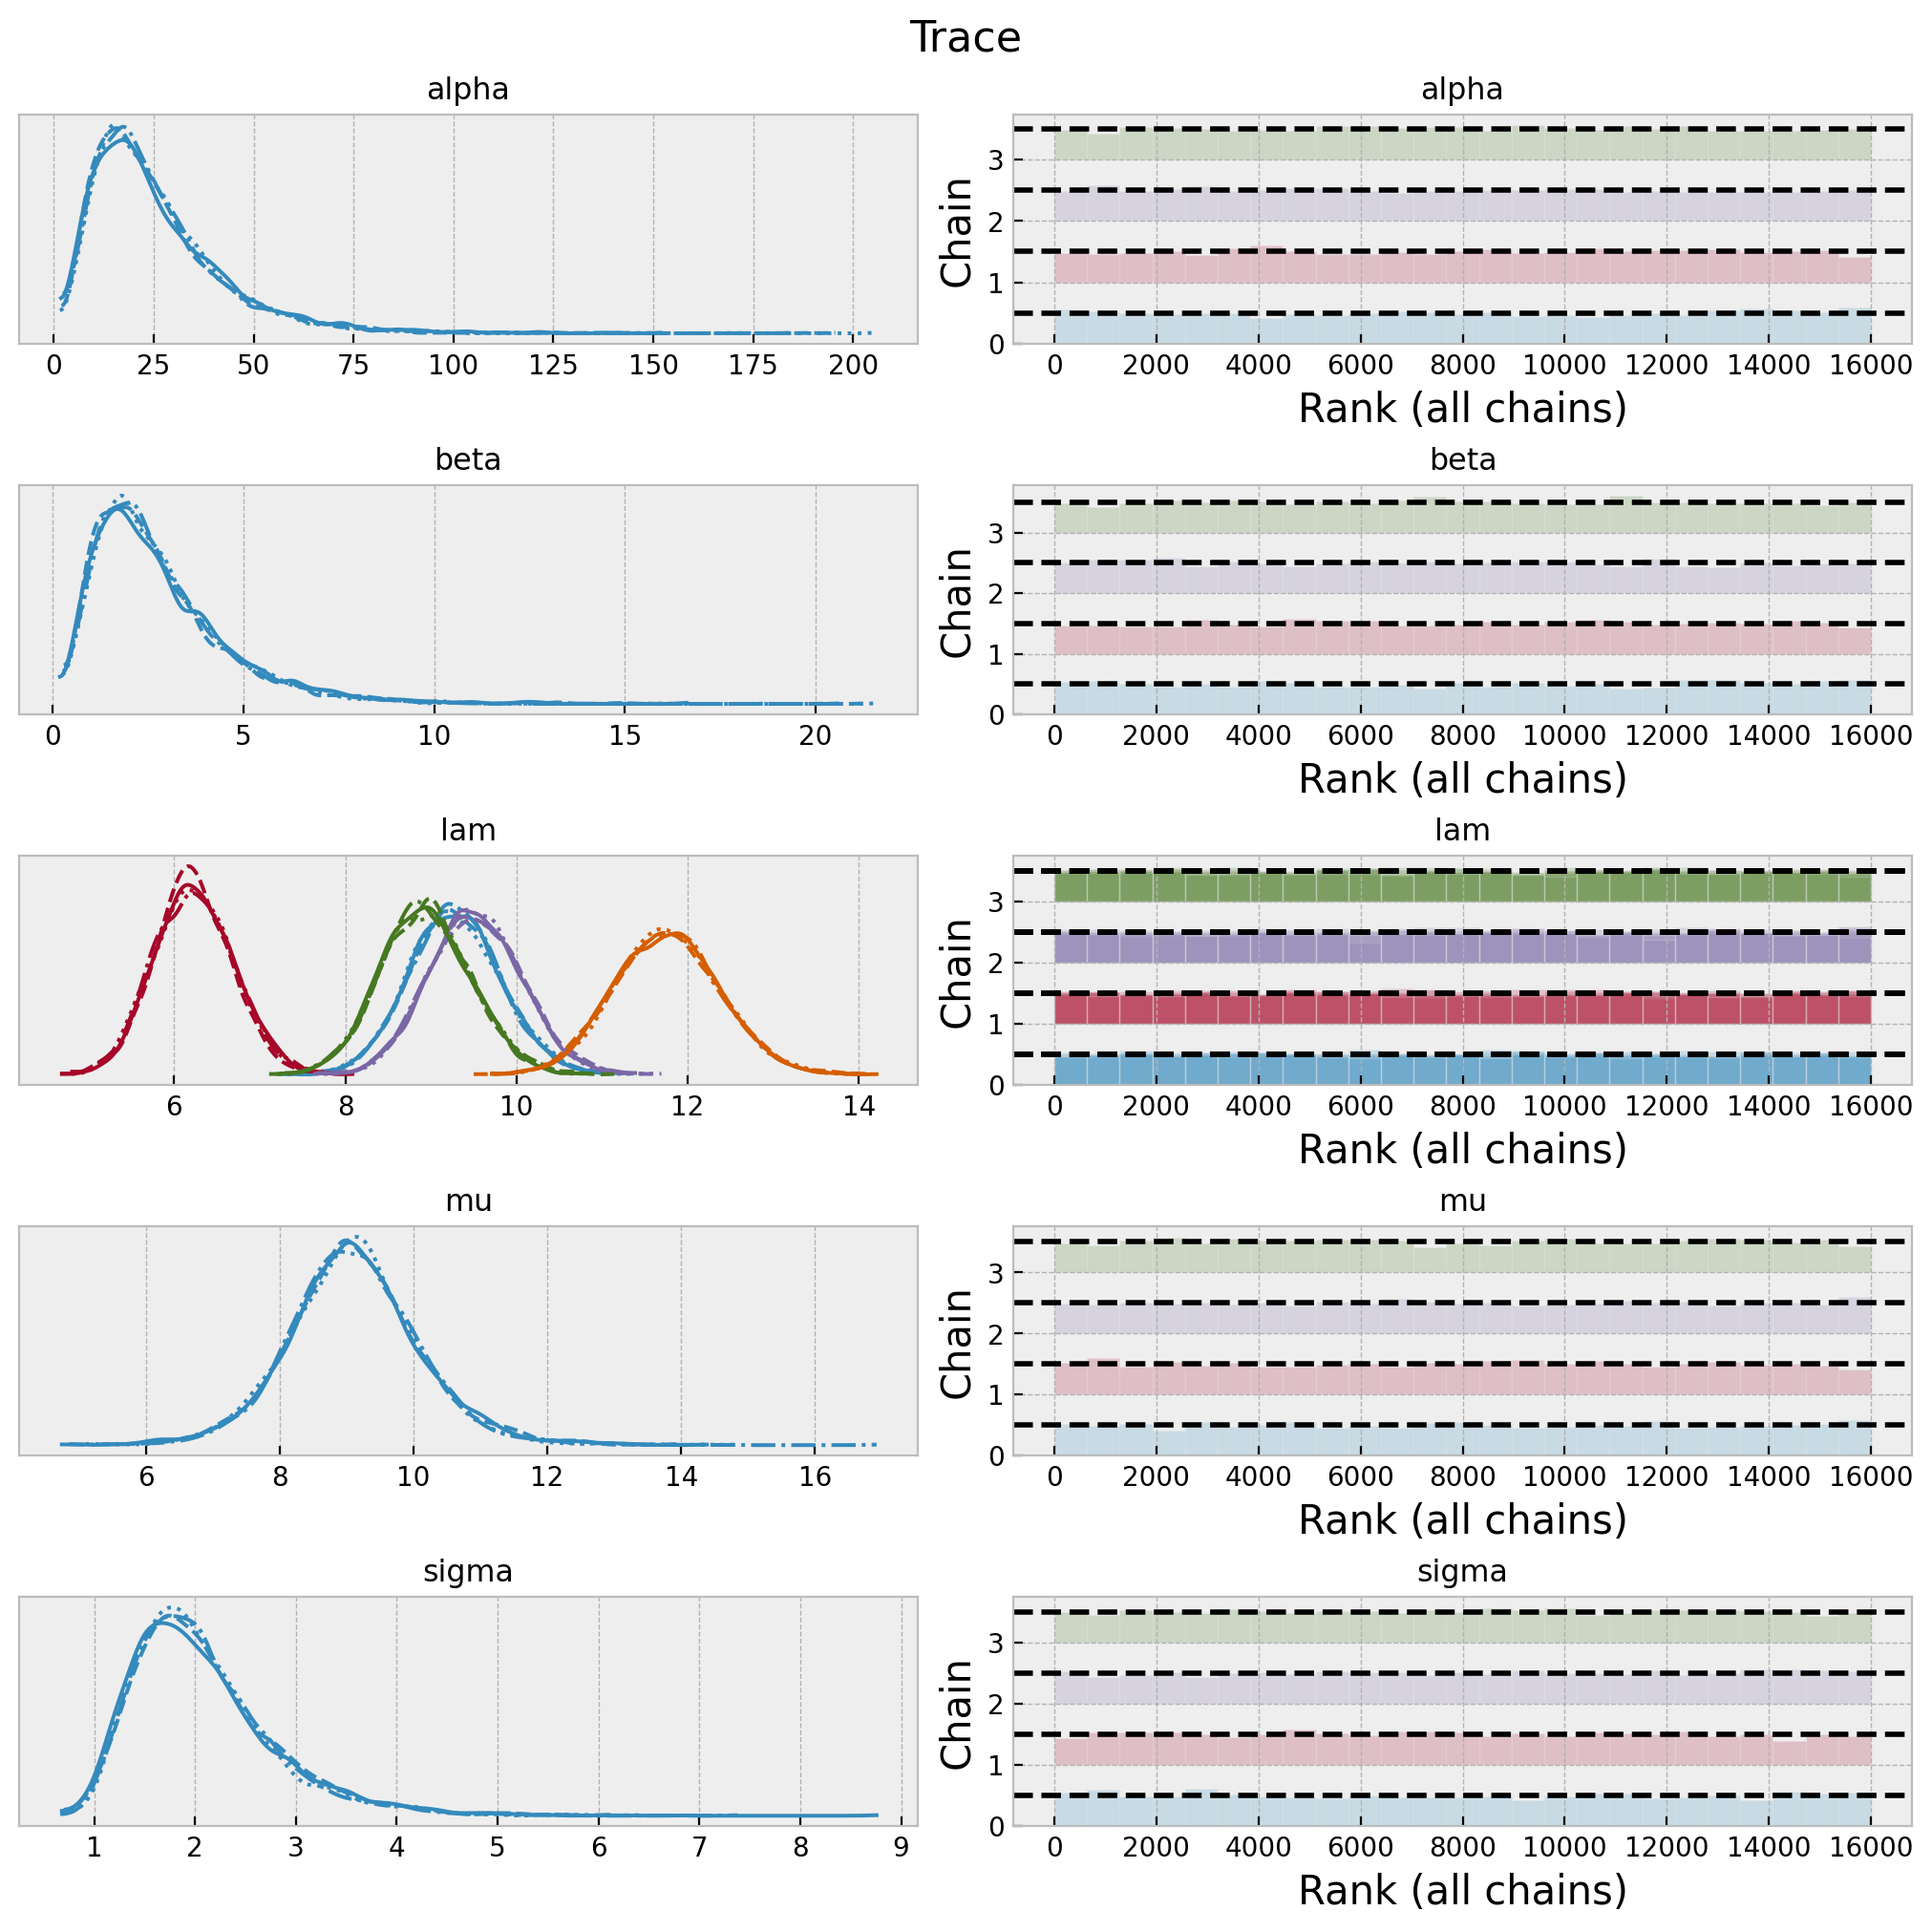

In [9]:
axes = az.plot_trace(
    data=idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Trace", fontsize=16);

In [10]:
az.summary(data=idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,25.472,16.540,2.978,54.796,0.142,0.103,13143.0,11525.0,1.0
beta,2.803,1.812,0.344,6.021,0.016,0.011,12791.0,11599.0,1.0
lam[0],9.285,0.534,8.290,10.305,0.004,0.003,19059.0,11931.0,1.0
lam[1],6.230,0.461,5.404,7.116,0.004,0.003,15813.0,13124.0,1.0
lam[2],9.522,0.537,8.500,10.508,0.004,0.003,18125.0,12496.0,1.0
lam[3],8.942,0.526,7.945,9.927,0.004,0.003,18684.0,12556.0,1.0
lam[4],11.760,0.611,10.631,12.919,0.005,0.003,17573.0,12329.0,1.0
mu,9.114,0.998,7.245,11.032,0.009,0.007,12304.0,10130.0,1.0
sigma,2.080,0.707,0.974,3.390,0.007,0.005,12551.0,10440.0,1.0


<AxesSubplot:xlabel='obs / obs'>

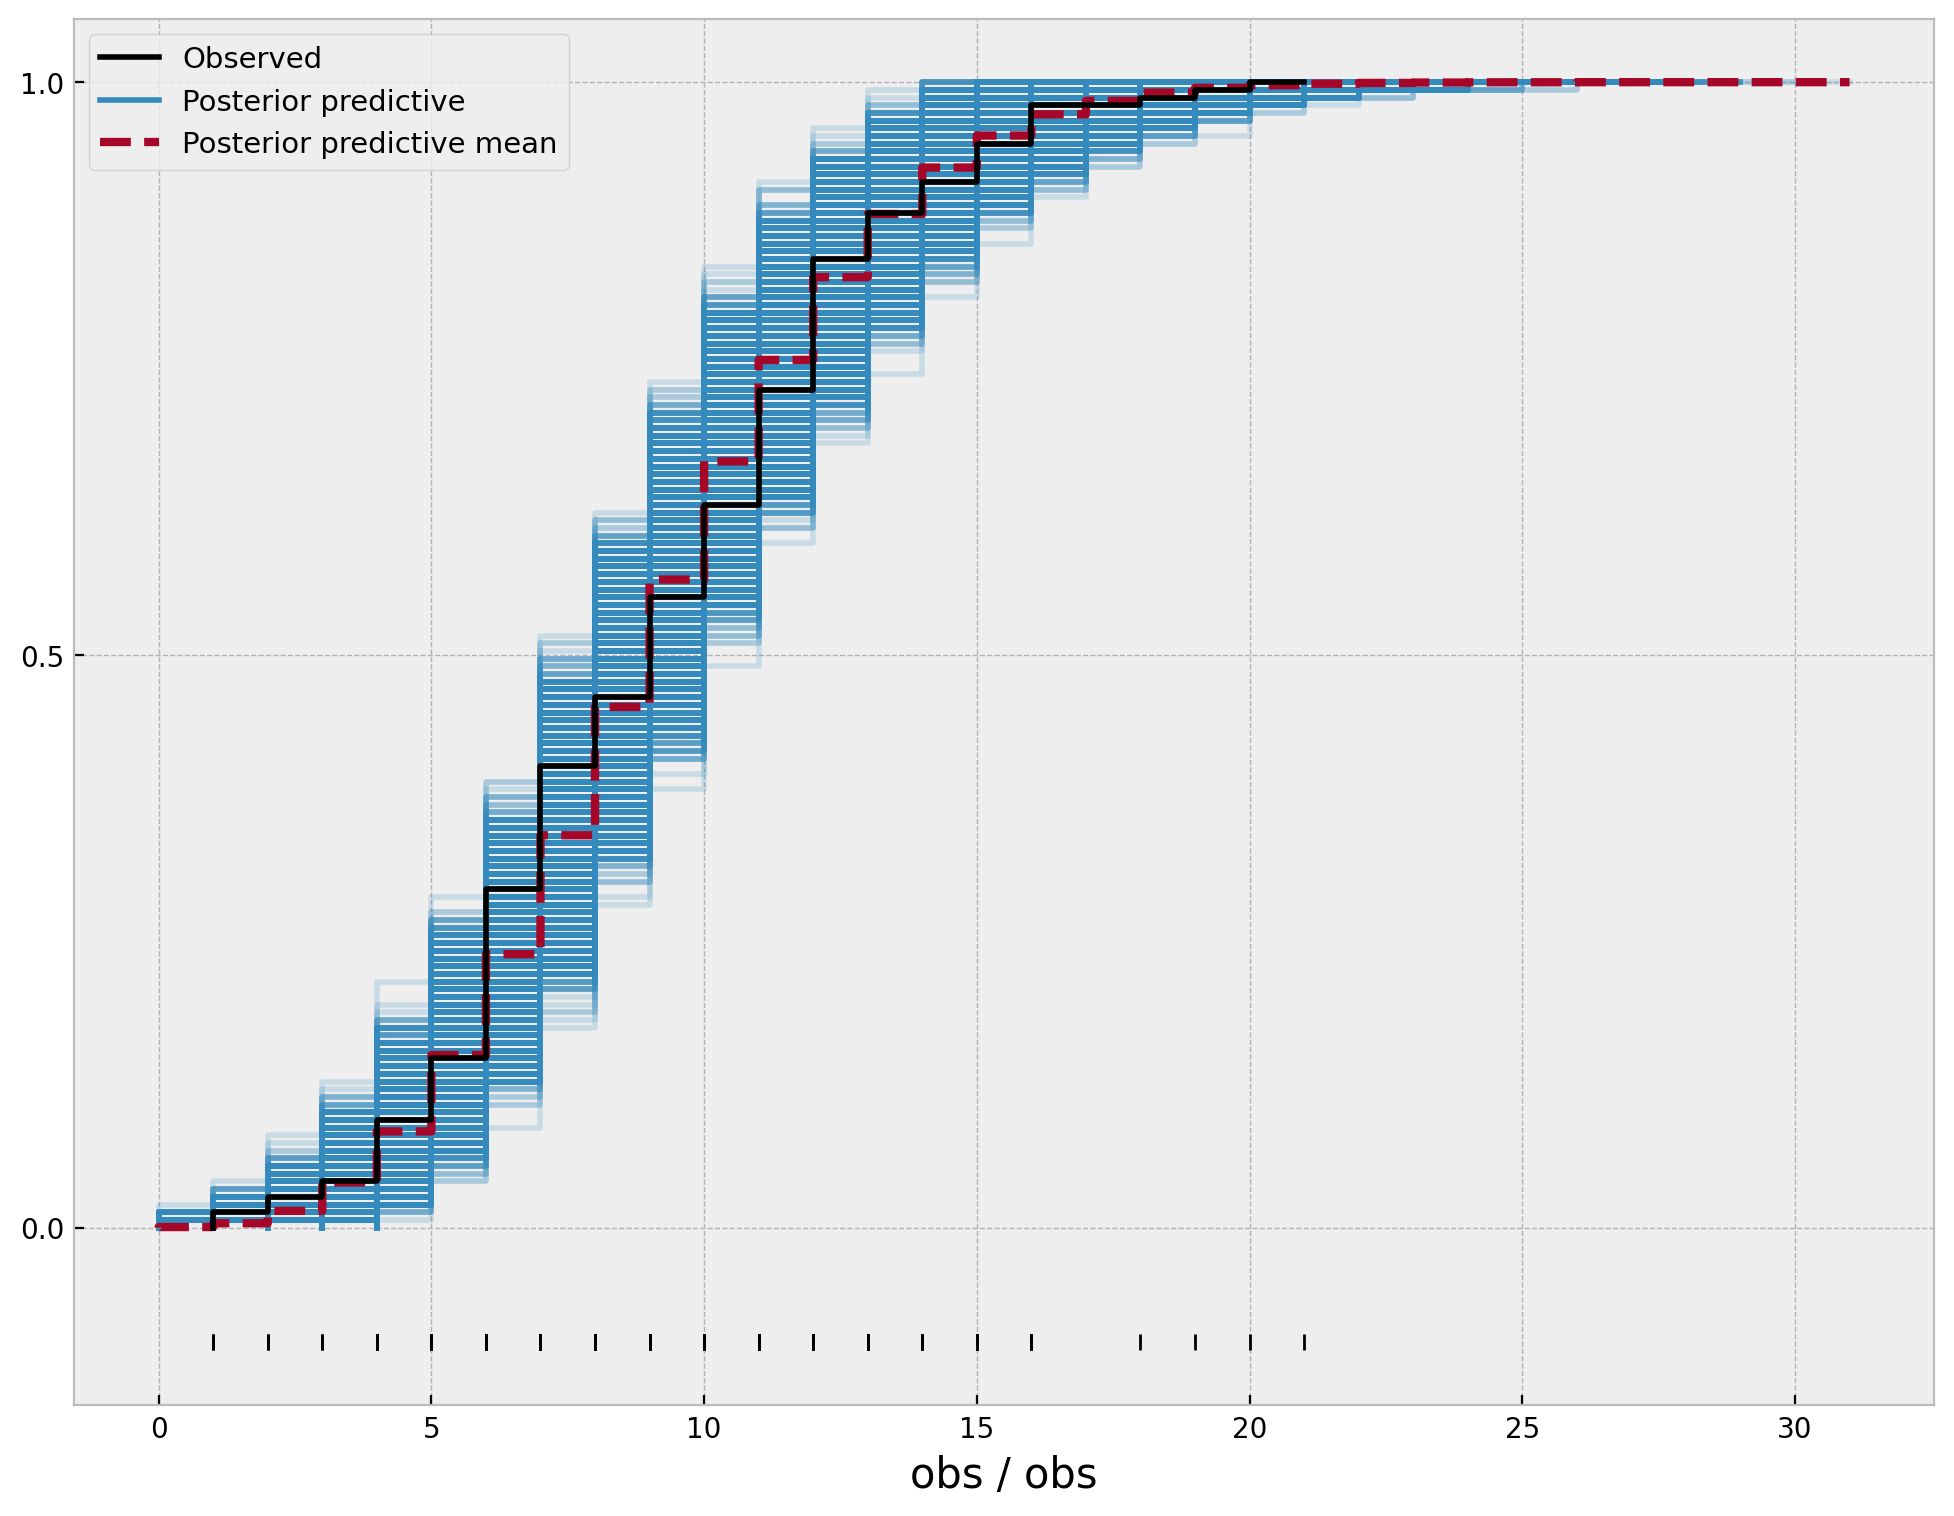

In [11]:
az.plot_ppc(
    data=idata,
    kind="cumulative",
    observed_rug=True,
    backend_kwargs={"figsize": (12, 9)},
)